In [1]:
%%capture
import numpy as np
from mitiq import zne
import h5py
from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile
import qiskit.providers.aer.noise as noise
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style(grid=False)

# import circuit needed

In [2]:
# simplified pauli measurement label and coefficient
simplified_h_diag_measure_list = [1, 11]
simplified_h_offdiag_measure_list = [0, 1, 3, 5, 11]
h_diag_coefficient_list = [-0.1779291653897952, 0.36978265527106347, -0.6365898571875489]
h_off_coefficient_list = [-0.6365898561329018, -0.17792916538979606, 0.153506530287386, 0.1535065227735808, 0.36978266455828424]

# import circuits used for estimating the overlap and hamiltonian matrix

# circuit for s offdiagonal 
qc_s_offdiagonal_qasm =  QuantumCircuit().from_qasm_str(open('qc_transpiled.qasm', 'r').read())
qc_s_offdiagonal = transpile(qc_s_offdiagonal_qasm, optimization_level=3, basis_gates=['u3','cx'])

# circuit for h offdiagonal
qc_h_offdiag_qasm = []
for i in simplified_h_offdiag_measure_list:
    qc_h_offdiag_qasm.append(QuantumCircuit().from_qasm_str(open('hamiltonian_term/hamiltonianterm'+str(i)+'.qasm', 'r').read()))

qc_h_offdiag_list = []
for qc in qc_h_offdiag_qasm:
    qc_h_offdiag_list.append(transpile(qc, optimization_level=3, basis_gates=['cx','u3']))

#circuit for h diagonal, using 4 qubits, simplified version
qc_h_diag_qasm = []
for i in simplified_h_diag_measure_list:
    qc_h_diag_qasm.append(QuantumCircuit().from_qasm_str(open('hamiltonian_term/hamiltonianterm_diagonal'+str(i)+'.qasm', 'r').read()))

qc_h_diag_list = []
for qc in qc_h_diag_qasm:
    qc_h_diag_list.append(transpile(qc, optimization_level=3, basis_gates=['cx','u3']))

# #circuit for h diagonal, using 9 qubits
# qc_diagonal_all_list= []
# for i in range(27):
#     qc_diagonal_all_list.append(QuantumCircuit().from_qasm_str(open('hamiltonian_term/hamiltonianterm_diagonal_all'+str(i)+'.qasm', 'r').read()))
    
# qc_diagonal_all_compiled_list = []
# for qc in qc_diagonal_all_list:
#     qc_diagonal_all_compiled_list.append(transpile(qc, optimization_level=3, basis_gates=['cx','u3']))

# qc_offdiag_without_measure_qasm =  QuantumCircuit().from_qasm_str(open('qc_offdiag_without_measure.qasm', 'r').read())
# qc_offdiag_without_measure = transpile(qc_offdiag_without_measure_qasm, optimization_level=3, basis_gates=['u3','cx'])

In [3]:
backend = Aer.get_backend('qasm_simulator')
backend.set_options(max_parallel_threads=0, max_parallel_experiments=0)

def tell_signal(measure_str):
    if measure_str.count('0') % 2 == 0:
        return 'minus'
    else:
        return 'plus'

# tell the expectation value
def tell_exp(result):
    tem_dic_keys = list(result.get_counts().keys())
    tem_dic_values = list(result.get_counts().values())
    tem_exp = 0
    l = len(tem_dic_keys)
    for i in range(l):
        if tell_signal(tem_dic_keys[i]) is 'minus':
            tem_exp += -tem_dic_values[i]
        elif tell_signal(tem_dic_keys[i]) is 'plus':
            tem_exp += tem_dic_values[i]
    return tem_exp

from scipy.linalg import eigh
def eigensolver(s, hoff, hdiag):
    S = np.array([[1, s.real],[s.real,1]])
    H = np.array([[hdiag.real, hoff.real],[hoff.real, hdiag.real]])
    eigvals = eigh(H, S, eigvals_only=True, subset_by_index=[0, 1])
    return eigvals

<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\17102\AppData\Local\Temp\ipykernel_51632\2248469637.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if tell_signal(tem_dic_keys[i]) is 'minus':
C:\Users\17102\AppData\Local\Temp\ipykernel_51632\2248469637.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif tell_signal(tem_dic_keys[i]) is 'plus':


In [4]:
def ibmq_executor(circuit, shots) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    # Simulate the circuit with noise
    result = execute(
        experiments=circuit,
        backend=backend,
        optimization_level=0,# Important to preserve folded gates.
        shots=shots,
    ).result()
    tem_exp = tell_exp(result)
    return tem_exp/shots

In [5]:
# 2q gate infidelity to the offdiagonal element of the S overlap matrix
def get_s(circuit, n, shots):
    
    overlap_unmitigated_list = []
    for _ in range(n):
        overlap_unmitigated_list.append(ibmq_executor(circuit, shots))

    return overlap_unmitigated_list

In [ ]:
def get_h_diag(circuit_list, n, shots):

    # H diagonal
    final_unmitigated_list = []
    l =len(circuit_list)

    for _ in range(n):
        pauli_unmitigated_list =[]
        for i in range(l):
            unmitigated = ibmq_executor(circuit_list[i], shots)
            pauli_unmitigated_list.append(unmitigated)
        final_unmitigated = 0
        for i in range(l):
            final_unmitigated += pauli_unmitigated_list[i]*float(h_diag_coefficient_list[i])
        final_unmitigated += h_diag_coefficient_list[2]
        final_unmitigated_list.append(final_unmitigated)
    return final_unmitigated_list

In [7]:
# 2q gate infidelity to the offdiagonal element of the Hamiltonian matrix
def get_h_offdiag(circuit_list, n, shots):
    # H diagonal
    final_unmitigated_list = []
    l =len(circuit_list)
    for a in range(n):
        pauli_unmitigated_list =[]
        for i in range(l):
            unmitigated = ibmq_executor(circuit_list[i], shots)
            pauli_unmitigated_list.append(unmitigated)
        final_unmitigated = 0
        for i in range(l):
            final_unmitigated += pauli_unmitigated_list[i]*float(h_off_coefficient_list[i])
        final_unmitigated_list.append(final_unmitigated)
    return final_unmitigated_list

# RUN EXP

In [8]:
# total shot = num_shots * 9 circuit * 5 extrapolation = 1e4 * 45 = 450000
total_shots = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
num_samples = 10
s_off_list = []
h_off_list = []
h_diag_list = []

for num_shots in total_shots:
    # 5min per 20
    s_off= get_s(circuit = qc_s_offdiagonal, n = num_samples, shots = int(num_shots/3))
    # 2 min per 20
    h_diag= get_h_diag(circuit_list = qc_h_diag_list, n = num_samples, shots = int(num_shots/3))
    # 20 min per 20
    h_off= get_h_offdiag(circuit_list = qc_h_offdiag_list, n = num_samples, shots = int(num_shots/3))
    s_off_list.append(s_off)
    h_off_list.append(h_off)
    h_diag_list.append(h_diag)
    print('num_shots:', num_shots, 'done')

num_shots: 100.0 done
num_shots: 1000.0 done
num_shots: 10000.0 done
num_shots: 100000.0 done
num_shots: 1000000.0 done
num_shots: 10000000.0 done


In [9]:
# calculate variance of h_off for different shots
h_off_var = []
for i in range(len(total_shots)):
    h_off_var.append(np.var(h_off_list[i]))
h_off_var

[0.0035945116250835707,
 0.0006117590325276231,
 1.3574866277629244e-05,
 6.850015975439763e-06,
 5.021589490309843e-07,
 5.3347274169982184e-08]

In [10]:
h_off_list_shadow = [[-0.49597728724409135, -0.47082709349621743, -0.3562638534979522, -0.3259505470543315, -0.8488833092538971, -0.627510799114967, -0.3827151694439184, -0.5614694333665607, -0.6100625385894948, -0.37552961137791085], [-0.8551716313056044, -0.7916005725411158, -0.8242137494040374, -0.9264716715371151, -0.9467723552909049, -0.8264839020073292, -0.8662403585148636, -0.8992152226509456, -0.8467296144943062, -0.8371979334425999], [-0.9163358386500453, -0.9009950879229902, -0.9129659254274696, -0.9505672079787874, -0.9273041714000138, -0.8976535620344046, -0.934592973976197, -0.9161655571213453, -0.9361120215430823, -1.0141954858878695], [-0.98206563352124, -0.954946032224308, -0.9238271317382, -0.958316415730363, -0.9362176497692745, -0.9709268677773554, -0.9304976692375115, -0.9736934070507057, -0.9543654771623137, -0.9503822332423429], [-0.9582392478518915, -0.9530037115154508, -0.9455464786194253, -0.9443928807723815, -0.9554203673704453, -0.9508642544946604, -0.938237756432405, -0.9476804631394808, -0.9509056187427569, -0.9490173054904303]]

In [12]:
len(h_off_list_shadow)

5

In [13]:
# similarly, calculate variance of h_off for different shots of shadow
h_off_var_shadow = []
for i in range(5):
    h_off_var_shadow.append(np.var(h_off_list_shadow[i]))
h_off_var_shadow

[0.023463537303884195,
 0.00212861282838354,
 0.0010128703159540404,
 0.00032714834890987254,
 2.9934673041165214e-05]

In [10]:
s0_list = []
s0_mean_list = []
t1_mean_list = []
s0_mae_list = []
s0_mae_std_list = []
t1_mae_list = []
s0_std_list = []
t1_std_list = []
for i in range(6):
    # calcualte energy using eigensovler
    s0 = []
    t1 = []
    for j in range(10):
        try:
            tmp_unmitigated = eigensolver(s_off_list[i][j], h_off_list[i][j], h_diag_list[i][j])
            s0_tmp = tmp_unmitigated[0]
            t1_tmp = tmp_unmitigated[1]
            s0.append(s0_tmp)
            t1.append(t1_tmp)
        except:
            print('error')
    s0_list.append(s0)
    s0_mean_list.append(np.mean(s0))
    s0_mae_list.append(np.mean([abs(s0_tmp + 1.053513) for s0_tmp in s0]))
    s0_mae_std_list.append(np.std([abs(s0_tmp + 1.053513) for s0_tmp in s0])/np.sqrt(10))
    t1_mean_list.append(np.mean(t1))
    t1_mae_list.append(np.mean([abs(t1_tmp + 0.82844334) for t1_tmp in t1]))
    s0_std_list.append(np.std(s0))
    t1_std_list.append(np.std(t1))


error


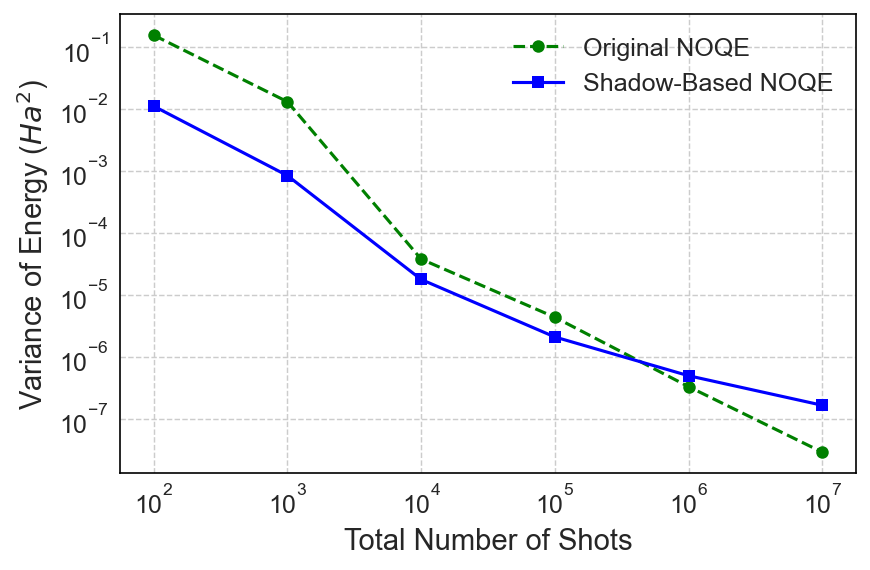

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
s0_hadamard_var_list = [np.var(x) for x in s0_list]
s0_shadow_var_list = [
    0.011244066976360444,
    0.0008518647051612698,
    1.796625216969076e-05,
    2.1192361109961945e-06,
    5.02149230921054e-07,
    1.6749912100400506e-07
]

total_shots = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]

# Configure plot settings
plt.figure(figsize=(6, 4), dpi=150)

# Plotting Hadamard variance
plt.plot(
    total_shots,
    s0_hadamard_var_list,
    label='Original NOQE',
    marker='o',
    linestyle='--',
    color='green',
    markersize=6,
    linewidth=1.5
)

# Plotting Shadow variance
plt.plot(
    total_shots,
    s0_shadow_var_list,
    label='Shadow-Based NOQE',
    marker='s',
    linestyle='-',
    color='blue',
    markersize=6,
    linewidth=1.5
)

# Logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')

# Axis labels
plt.xlabel('Total Number of Shots', fontsize=14)
plt.ylabel('Variance of Energy ($Ha^2$)', fontsize=14)

# Legend customization
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Custom ticks
plt.xticks(total_shots, fontsize=12)
plt.yticks(fontsize=12)

# Grid customization for a less dense grid
plt.grid(True, which='major', linestyle='--', linewidth=0.7)

# No minor ticks to avoid excessive gridlines
plt.minorticks_off()

ax = plt.gca()  # Get the current axis
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set the color of the spines
    spine.set_linewidth(0.8)  # Set the thickness of the frame
    
# Adjust layout for compactness
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('figures/variance_comparison.pdf', format='pdf', dpi=300)

# Show the plot
plt.show()

In [17]:
plt.plot(s0_hadamard_var_list, label='Hadamard')
plt.plot(s0_mae_std_shadow_list, label='Shadow')
# log scale of y
plt.yscale('log')
plt.xlabel('log10(shots)')
plt.ylabel('Variance')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
import ast
df = pd.read_csv("data/shadow_noiseless.csv")
columns_to_process = ['s_off', 'h_off', 'h_diag', 's0', 't1', 'fidelity1', 'fidelity2']
s_off_list = df['s_off'].apply(ast.literal_eval).tolist()
h_off_list = df['h_off'].apply(ast.literal_eval).tolist()
h_diag_list = df['h_diag'].apply(ast.literal_eval).tolist()
s0_list = df['s0'].apply(ast.literal_eval).tolist()
t1_list = df['t1'].apply(ast.literal_eval).tolist()
fidelity1_list = df['fidelity1'].apply(ast.literal_eval).tolist()
fidelity2_list = df['fidelity2'].apply(ast.literal_eval).tolist()

data = {
    "s_off": s_off_list,
    "h_off": h_off_list,
    "h_diag": h_diag_list,
    "s0": s0_list,
    "t1": t1_list,
    "fidelity1": fidelity1_list,
    "fidelity2": fidelity2_list
}
df = pd.DataFrame(data)
#df.to_csv("data/shadow_noiseless.csv")

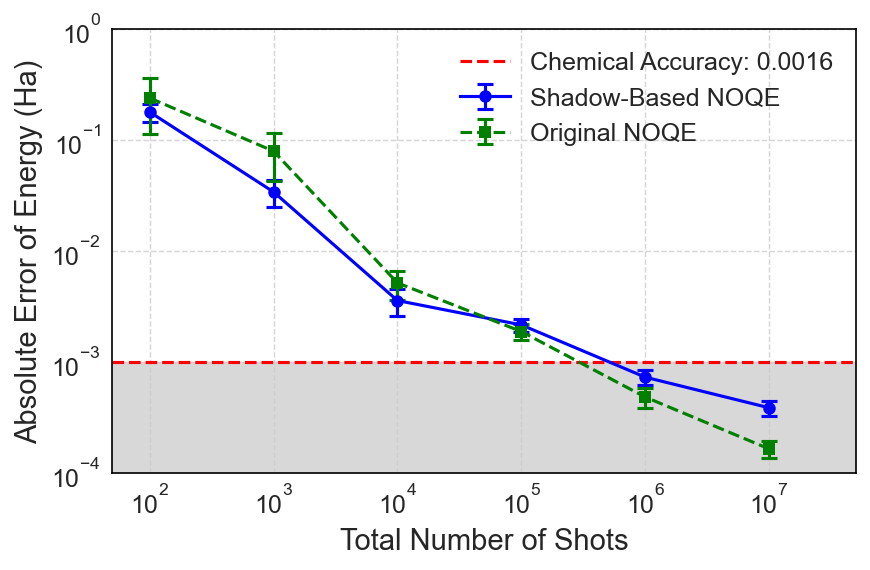

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data
shadow_compared = [0.17844461579521836, 0.03399790797280213, 0.0035746129835466435, 
                   0.002157278395948392, 0.0007297894039619779, 0.0003867574940570995]

s0_mae_std_shadow_list = [0.03353217406664895,
 0.009205833573975754,
 0.0010058245485003198,
 0.00029012116568627596,
 0.00011258767004351767,
 6.257120460486188e-05]

chemical_accuracy = 0.001  # Define the chemical accuracy threshold

plt.figure(figsize=(6, 4), dpi=150)  # High resolution and compact size

plt.errorbar(total_shots, shadow_compared, yerr=s0_mae_std_shadow_list, fmt='o', linestyle='-', linewidth=1.5, 
             markersize=6, label='Shadow-Based NOQE', color='blue', capsize=4, elinewidth=1.5, capthick=1.5, zorder=3)

plt.errorbar(total_shots, s0_mae_list, yerr=s0_mae_std_list, fmt='s', linestyle='--', linewidth=1.5, 
             markersize=6, label='Original NOQE', color='green', capsize=4, elinewidth=1.5, capthick=1.5, zorder=3)


# Add horizontal line for chemical accuracy
plt.axhline(y=chemical_accuracy, color='red', linestyle='--', linewidth=1.5, label='Chemical Accuracy: 0.0016')

# Shade region below the chemical accuracy line
plt.fill_between([50, 5e7], 1e-4, chemical_accuracy, color='gray', alpha=0.3)

# Set logarithmic scales for both axes
plt.xscale('log')
plt.yscale('log')
plt.xlim(50, 5e7)
plt.ylim(1e-4, 1)

# Axis labels
plt.xlabel('Total Number of Shots', fontsize=14)
plt.ylabel('Absolute Error of Energy (Ha)', fontsize=14)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=12, frameon=False, loc='upper right')
# Add grid
plt.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.8)

# Add a visible black frame
ax = plt.gca()  # Get the current axis
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set the color of the spines
    spine.set_linewidth(0.8)  # Set the thickness of the frame

# Adjust layout for compactness
plt.tight_layout()

# Save the plot as a vector graphic
plt.savefig("figures/mae.pdf", format="pdf", dpi=300)

# Show the plot
plt.show()

In [ ]:
# df = pd.read_csv("data/shadow_noiseless.csv")
# columns_to_process = ['s_off', 'h_off', 'h_diag', 's0', 't1', 'fidelity1', 'fidelity2']
# s_off_list = df['s_off'].apply(ast.literal_eval).tolist()
# h_off_list = df['h_off'].apply(ast.literal_eval).tolist()
# h_diag_list = df['h_diag'].apply(ast.literal_eval).tolist()
# s0_list = df['s0'].apply(ast.literal_eval).tolist()
# t1_list = df['t1'].apply(ast.literal_eval).tolist()
# fidelity1_list = df['fidelity1'].apply(ast.literal_eval).tolist()
# fidelity2_list = df['fidelity2'].apply(ast.literal_eval).tolist()

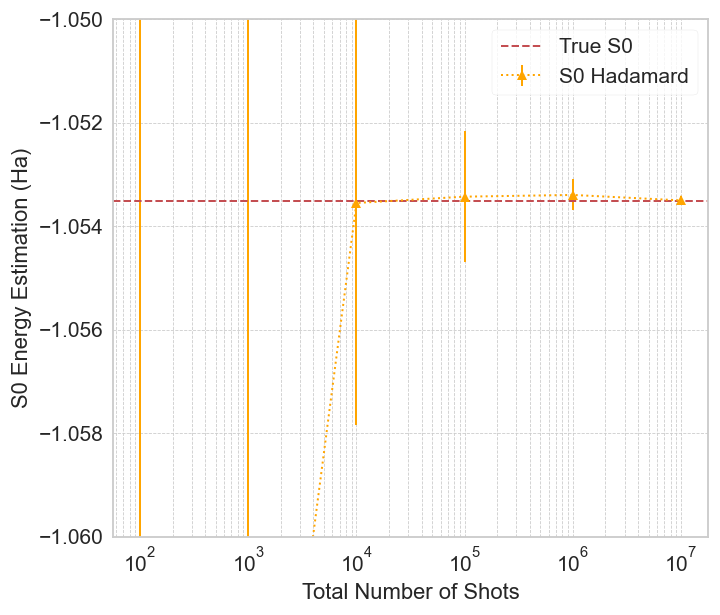

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(dpi=120)
#plt.errorbar(total_shots, [np.mean(x) for x in s0_list], yerr=[np.std(x) for x in s0_list], marker='D', linestyle='-.', color='purple', capsize=5, label="S0 Shadow")
plt.errorbar(total_shots, s0_mean_list, yerr= s0_std_list, marker='^', linestyle=':', color='orange', label="S0 Hadamard")
# Add horizontal line for true S0
plt.axhline(y=-1.053513, color='r', linestyle='--', label='True S0')
#plt.axhline(y=-0.828443, color='r', linestyle='--', label='True T1')

# Set logarithmic scale for x-axis
plt.xscale('log')

# Add labels and title
plt.xlabel('Total Number of Shots')
plt.ylabel('S0 Energy Estimation (Ha)')
#plt.title('S0 vs Total Number of Shots')

# Add grid for better readability
plt.grid(True, which="both", ls="--", lw=0.5)
plt.ylim(-1.06, -1.05)

# Add legend
plt.legend()

# Show the plot
plt.show()

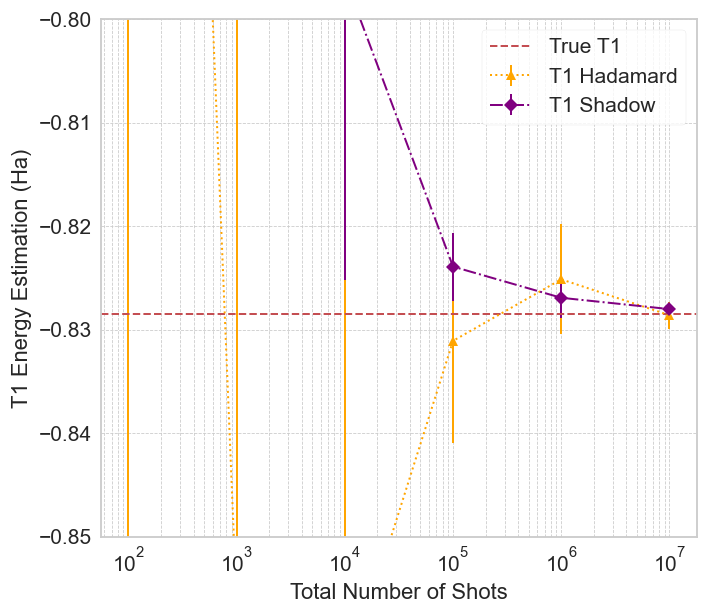

In [51]:
plt.figure(dpi=120)
plt.errorbar(total_shots, t1_mean_list, yerr= t1_std_list, marker='^', linestyle=':', color='orange', label="T1 Hadamard")
plt.errorbar(total_shots, [np.mean(x) for x in t1_list], yerr=[np.std(x) for x in t1_list], marker='D', linestyle='-.', color='purple', capsize=5, label="T1 Shadow")
# Add horizontal line for true S0
#plt.axhline(y=-1.053513, color='r', linestyle='--', label='True S0')
plt.axhline(y=-0.828443, color='r', linestyle='--', label='True T1')

# Set logarithmic scale for x-axis
plt.xscale('log')

# Add labels and title
plt.xlabel('Total Number of Shots')
plt.ylabel('T1 Energy Estimation (Ha)')
#plt.title('S0 vs Total Number of Shots')

# Add grid for better readability
plt.grid(True, which="both", ls="--", lw=0.5)
plt.ylim(-0.85, -0.8)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [9]:
s0 = []
t1 = []
for i in range(num_samples):
    tmp_unmitigated = eigensolver(s_off[i], h_off[i], h_diag[i])
    s0.append(tmp_unmitigated[0])
    t1.append(tmp_unmitigated[1])

In [10]:
hadamard_noiselss = pd.DataFrame({'s_off': s_off, 'h_off': h_off, 'h_diag': h_diag, 's0': s0, 't1': t1})
hadamard_noiselss.to_csv('data/hadamard_noiseless.csv')